In [20]:
#!pip install yellowbrick

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from utils import columns, clean_df, numerics, summary
from pycaret.regression import *
from yellowbrick.regressor import PredictionError

%config Completer.use_jedi = False
seed = 1

# Agenda
1. Problem
2. EDA
3. Solution
    - Base Model (multivariate linear regression)
    - Advanced Framework
    - Production Scenario
4. Conclusion

# 1. Problem
- Simple regression model
- Target: **normalized losses** ~ "*relative average loss payment per insured vehicle year.*" ([UCI](https://archive.ics.uci.edu/ml/datasets/Automobile))
- Evaluate with MSE

# 2. EDA

This looks nice: https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c

In [2]:
df = pd.read_csv("data/imports-85.data", header=None, names=columns)
df = clean_df(df)
df.head(3)

164 rows (80.0%) left after preprocessing


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
6,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0


In [3]:
# histogram target + log(target)
#pd.Series(np.log(y)).plot.hist()
#y.plot.hist()





# fancy stuff to display relations





# 3. Solution
## 3.1 Base Model (multivariate linear regression)
In our simple approach we'll consider continuous variables only.

In [4]:
# TODO: Check for linearity etc (use scripts from previous notebook)

cols = list(df.columns)
target, num_features = cols[0], [c for c in cols[1:] if c in numerics]

X,y = df[num_features], df[target]

#X,y = pd.get_dummies(df[cols[1:]]),np.log(df[target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

model = LinearRegression().fit(X_train, y_train)
summary(model, X_train, y_train)

Call:
lm(formula = normalized-losses ~ wheel-base + length + width + height + curb-weight + engine-size + bore + stroke + compression-ratio + horsepower + peak-rpm + city-mpg + highway-mpg + price) 

                       Coefficients  Std. Error  t value  Pr(>|t|)
0         (Intercept)      640.8757     202.433    3.166     0.002
1          wheel-base       -0.0631       1.249   -0.050     0.960
2              length        0.3062       0.635    0.482     0.630
3               width       -2.3873       3.173   -0.752     0.453
4              height       -7.3286       1.663   -4.407     0.000
5         curb-weight        0.0166       0.021    0.776     0.439
6         engine-size        0.2202       0.224    0.982     0.328
7                bore      -30.1966      14.665   -2.059     0.041
8              stroke      -18.4746      10.813   -1.709     0.090
9   compression-ratio        0.8409       1.014    0.830     0.408
10         horsepower       -0.0574       0.223   -0.257     0.

In [5]:
MSE = mean_squared_error(y_test, model.predict(X_test))
RMSE = mean_squared_error(y_test, model.predict(X_test), squared=False)

print(MSE,RMSE) # reversing log via exp for interpretability of MSE

330.17298736907463 18.170662821401827


Doesn't look too bad considering a terrible R squared of 0.37.

## 3.2 Advanced Framework
Instead of writing ✍️ a parameter optimization and apply stacking by hand, I use pycaret since it saves me a lot of time.

In [49]:
data = df.sample(frac=0.9, random_state=seed)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (148, 25)
Unseen Data For Predictions: (16, 25)


In [118]:
params = {
    "data": data,
    "target": "normalized-losses",
    "train_size": 0.8,
    "categorical_features": [c for c in cols[1:] if c not in numerics],
    "remove_multicollinearity": True,
    "verbose": False,
    "silent": True,
    "fold": 10,
    "session_id": seed,
    "feature_selection": True,
    "feature_selection_threshold": 0.1,
}

regr = setup(**params)

In [133]:
# Find best models
top3 = compare_models(n_select = 3,sort = 'MSE',
                      exclude=['huber','lar','par', 'knn', 'llar', 'br', 'en','lr'],
                      #verbose=False
                     )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,13.4400,452.0632,20.3641,0.3382,0.1546,0.1109,0.0100
et,Extra Trees Regressor,13.4089,574.6827,21.6013,0.1053,0.1653,0.1108,0.0350
rf,Random Forest Regressor,16.9055,625.2223,23.7245,-0.0568,0.1813,0.1412,0.0360
lightgbm,Light Gradient Boosting Machine,18.1105,629.8907,24.1215,-0.0976,0.1861,0.1521,0.0060
dt,Decision Tree Regressor,13.7008,693.7939,23.8646,0.1835,0.1804,0.1035,0.0040
ada,AdaBoost Regressor,19.7392,715.6153,25.4962,-0.2288,0.1982,0.1681,0.0130
ridge,Ridge Regression,23.8477,905.5051,28.9074,-0.3244,0.2272,0.2005,0.0050
lasso,Lasso Regression,24.0142,919.8104,29.1121,-0.3057,0.2298,0.2014,0.0050
omp,Orthogonal Matching Pursuit,26.7290,1158.4331,33.1413,-0.9127,0.2625,0.2290,0.0040


In [134]:
stacker = stack_models(estimator_list = top3[1:], meta_model = top3[0], 
                       #verbose=False
                      )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,13.1886,317.4531,17.8172,0.6599,0.1363,0.1005
1,12.5891,254.2801,15.9462,0.6690,0.1356,0.1172
2,14.5375,327.2451,18.0899,-1.1963,0.1887,0.1743
3,17.8177,776.8427,27.8719,0.5956,0.1750,0.1179
4,8.8786,192.9199,13.8896,0.7531,0.1123,0.0772
5,10.3841,265.5452,16.2956,0.7851,0.1377,0.0826
6,16.6461,726.0531,26.9454,0.4389,0.1827,0.1175
7,16.8752,418.1002,20.4475,0.2748,0.1570,0.1442
8,21.8311,1675.7831,40.9363,0.2735,0.2370,0.1359
9,23.7148,1196.4711,34.5900,-1.2713,0.2570,0.2044


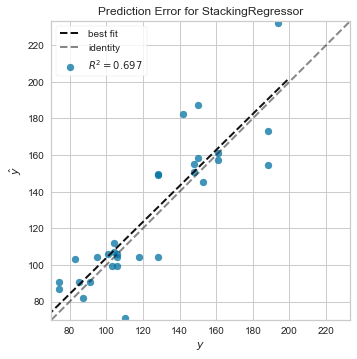

In [135]:
plot_model(stacker, 'error')

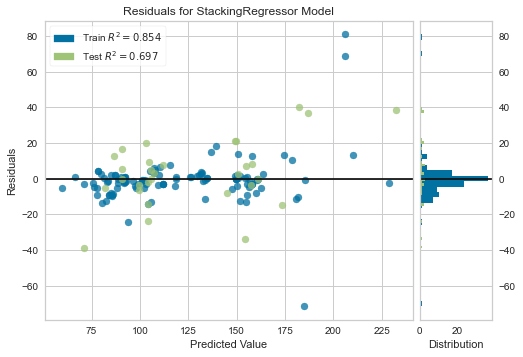

In [136]:
plot_model(stacker, 'residuals')

In [137]:
save_model(stacker, "stacked_regressior_01")
loaded_model = load_model("stacked_regressior_01")

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Successfully Loaded


<AxesSubplot:ylabel='Frequency'>

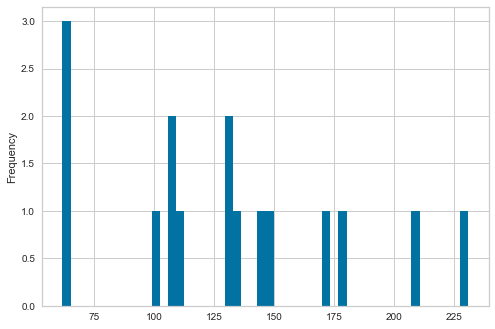

In [138]:
predictions = predict_model(loaded_model, data = data_unseen[list(data_unseen.columns)[1:]])
predictions["Label"].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

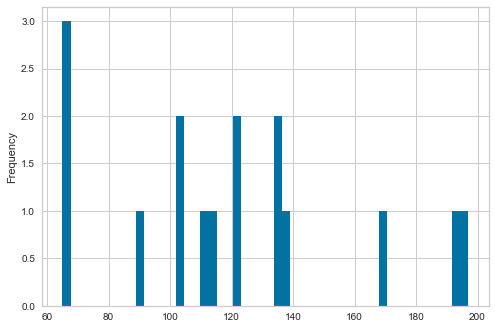

In [139]:
data_unseen["normalized-losses"].plot.hist(bins=50)

In [14]:
help(setup)
#help(compare_models)
#help(plot_model)
#help(predict_model)

Help on function setup in module pycaret.regression:

setup(data: pandas.core.frame.DataFrame, target: str, train_size: float = 0.7, test_data: Union[pandas.core.frame.DataFrame, NoneType] = None, preprocess: bool = True, imputation_type: str = 'simple', iterative_imputation_iters: int = 5, categorical_features: Union[List[str], NoneType] = None, categorical_imputation: str = 'constant', categorical_iterative_imputer: Union[str, Any] = 'lightgbm', ordinal_features: Union[Dict[str, list], NoneType] = None, high_cardinality_features: Union[List[str], NoneType] = None, high_cardinality_method: str = 'frequency', numeric_features: Union[List[str], NoneType] = None, numeric_imputation: str = 'mean', numeric_iterative_imputer: Union[str, Any] = 'lightgbm', date_features: Union[List[str], NoneType] = None, ignore_features: Union[List[str], NoneType] = None, normalize: bool = False, normalize_method: str = 'zscore', transformation: bool = False, transformation_method: str = 'yeo-johnson', hand

## 3.3 Production Scenario

# Conclusion

### Sources
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
- https://boostedml.com/2019/06/linear-regression-in-r-interpreting-summarylm.html
- https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
- 